In [1322]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

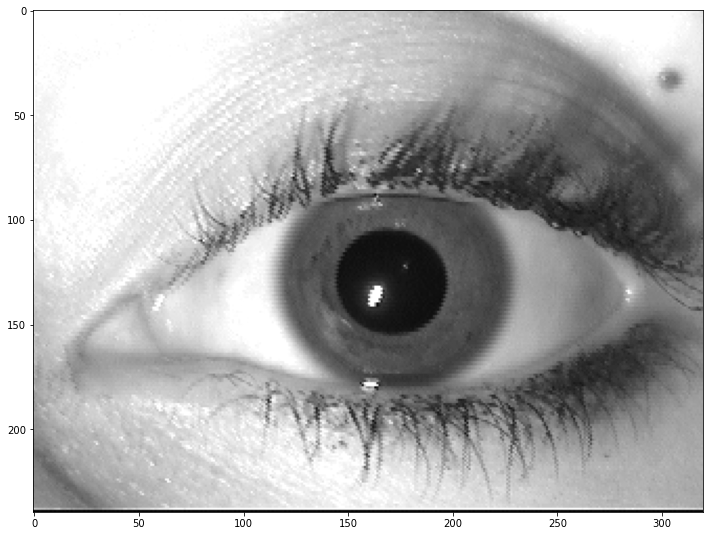

In [1323]:
def plot_gray(img):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img, cmap='gray')

def plot(img):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img)   

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return image

def get_all_images(root):
    images = []
    for i in range(len(os.listdir(root))):
        for subfolder in os.listdir(os.path.join(root, str(i + 1))): 
            for file in os.listdir(os.path.join(root, str(i + 1), subfolder)):
                if file.endswith('.bmp'):
                    image_path= os.path.join(root, str(i + 1), subfolder, file)
                    image = read_image(image_path)
                    images.append(image)
    return images

path = "MMU_Iris_v1\\8\\left\\fatmal2.bmp"

image = read_image(path)
plot_gray(image)

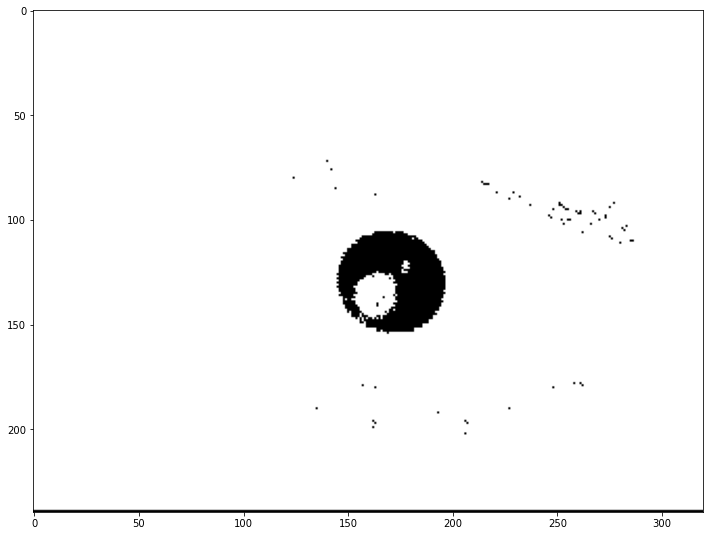

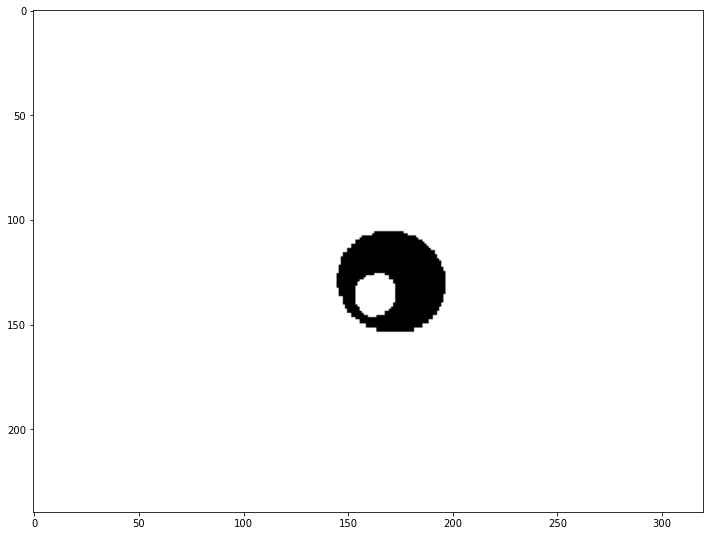

In [1324]:
def get_pupil(image):
    _, thr = cv2.threshold(image, 28, 255, cv2.THRESH_BINARY)
    thr2 = cv2.morphologyEx(thr, cv2.MORPH_OPEN, np.ones([3, 3]))
    thr2 = cv2.morphologyEx(thr2, cv2.MORPH_CLOSE, np.ones([3, 3]))
    return thr, thr2

thr, thr2 = get_pupil(image)
plot_gray(thr)
plot_gray(thr2)

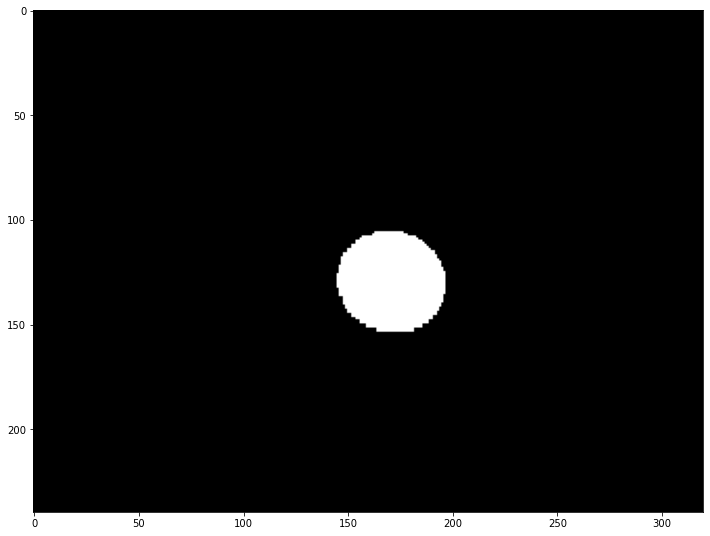

In [1325]:
def get_pupil_inv(thr2):
    thr_inv = cv2.bitwise_not(thr2)
    thr_inv = cv2.morphologyEx(thr_inv, cv2.MORPH_CLOSE, np.ones([3, 3]), iterations=10)
    return thr_inv

thr_inv = get_pupil_inv(thr2)
plot_gray(thr_inv)

In [1326]:
def fit_ellipse(thr_inv):
    cnt, _ = cv2.findContours(thr_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # assert len(cnt) == 1 # fix if 2 areas were found
    if len(cnt) > 1:
        sizes = [i.shape[0] for i in cnt]
        ind_max = np.argmax(sizes)
        cnt = [cnt[ind_max]]
    ell = cv2.fitEllipse(cnt[0])
    return cnt, ell

cnt, ell = fit_ellipse(thr_inv)
ell

((170.72128295898438, 129.59722900390625),
 (47.3367919921875, 51.64118957519531),
 108.92933654785156)

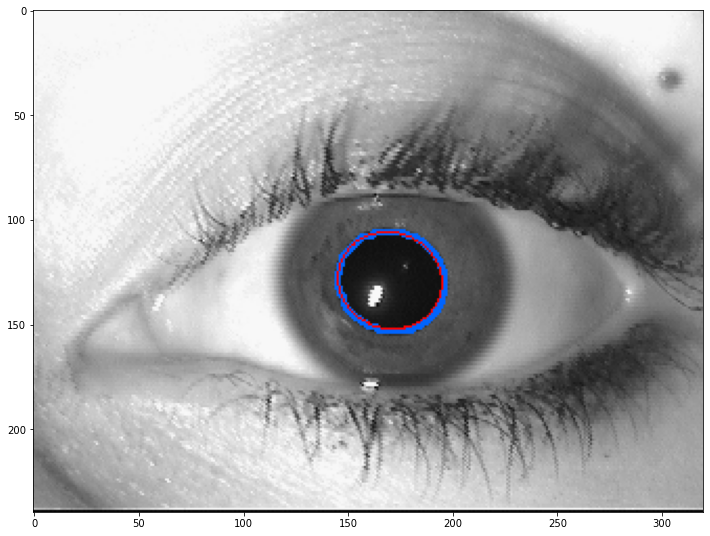

In [1327]:
img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

def draw_pupil(img_color, cnt, ell):
    center = [int(x) for x in ell[0]]
    a = [int(x) // 2 for x in ell[1]]

    radius_pupil = int(np.ceil(np.mean(a)))
    cv2.drawContours(img_color, cnt, -1, (0, 100, 255), thickness=2)
    cv2.ellipse(img_color, center, a, ell[2], 0, 360, (255, 0, 0))
    # cv2.circle(img_color, center, radius_pupil, (255, 0, 0))
    return center, radius_pupil

center, radius_pupil = draw_pupil(img_color, cnt, ell)
plot(img_color)

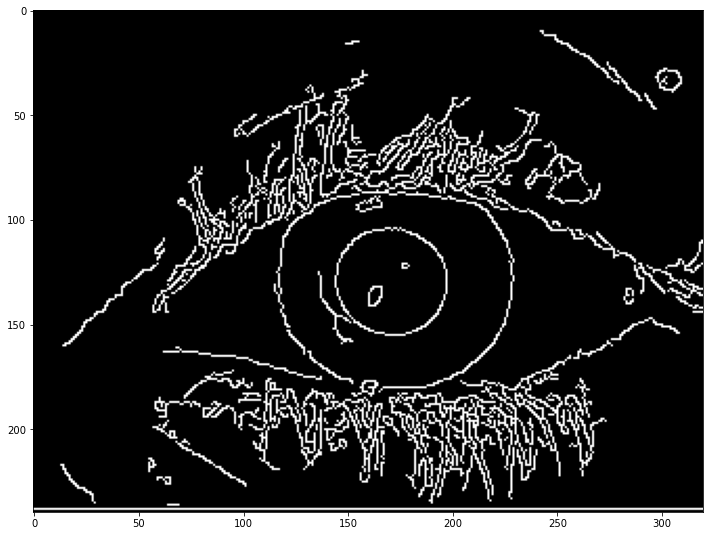

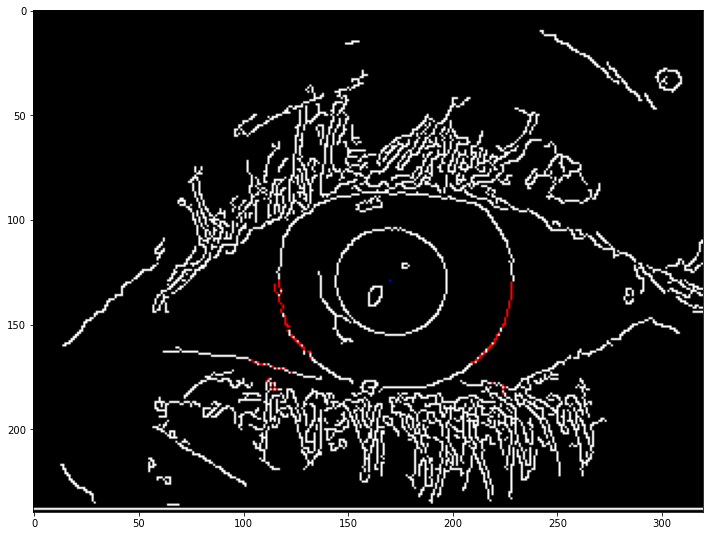

In [1328]:
# iris part MATH

def extract_poi(edges, cent_geom, radius_pupil, margin=15, eps=0.4):
    poi = []
    poi_geom = []
    k_hor, b_hor = line_eq(cent_geom, -180)
    k_135, b_135 = line_eq(cent_geom, -135)
    k_45, b_45 = line_eq(cent_geom, -45)

    edges_copy = np.copy(edges)
    for i in range(egdes_copy.shape[0]):
        for j in range(egdes_copy.shape[1]):
            y_geom = egdes_copy.shape[0] - i
            if (radius_pupil + margin) ** 2 <= (j - cent_geom[0]) ** 2 + (y_geom - cent_geom[1]) ** 2 <=  (3.2 * radius_pupil) ** 2:
                if y_geom <= k_hor * j + b_hor and y_geom >= k_135 * j + b_135: # inside
                    for a in range(-180, -135):
                        k, b = line_eq(cent_geom, a)
                        ray_points = []
                        if abs(y_geom - (k * j + b)) < eps and edges[i][j] == 255: # belongs to ray and white
                            if [j, y_geom] not in ray_points:
                                ray_points.append([j, y_geom])
                        if ray_points:
                            for point in ray_points:
                                if distance_between(point, cent_geom) == np.min([distance_between(point, cent_geom) for point in ray_points]):                                            
                                    poi.append([j, i])
                                    poi_geom.append([j, y_geom])

                if y_geom <= k_hor * j + b_hor and y_geom >= k_45 * j + b_45: # inside  
                    for a in range(-45, 0):
                        k, b = line_eq(cent_geom, a)
                        ray_points = []
                        if abs(y_geom - (k * j + b)) < eps and edges[i][j] == 255: # belongs to ray and white
                            if [j, y_geom] not in ray_points:
                                ray_points.append([j, y_geom])
                        if ray_points:
                            for point in ray_points:
                                if distance_between(point, cent_geom) == np.min([distance_between(point, cent_geom) for point in ray_points]):                                            
                                    poi.append([j, i])
                                    poi_geom.append([j, y_geom])
    return poi, poi_geom

def distance_between(point1, point2):
    return ((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)**0.5

def line_eq(point, angle):
    k = np.tan((angle + 180) * np.pi / 180)
    b = point[1] - k * point[0]
    return k, b

def plot_color_edge_contours(edges, poi):
    edge_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    for p in poi:
        cv2.circle(edge_color, p, 0, color=(255, 0, 0), thickness=-1)
    cv2.circle(edge_color, center, 0, color=(0, 0, 255), thickness=-1)
    plot(edge_color)

image_blurred = cv2.GaussianBlur(image,(3,3),0)
edges = cv2.Canny(image_blurred, 40, 140)
plot_gray(edges)
cent_geom = [center[0], edges.shape[0] - center[1]]
poi, poi_geom = extract_poi(edges, cent_geom, radius_pupil, margin=20, eps=0.4)
plot_color_edge_contours(edges, poi)


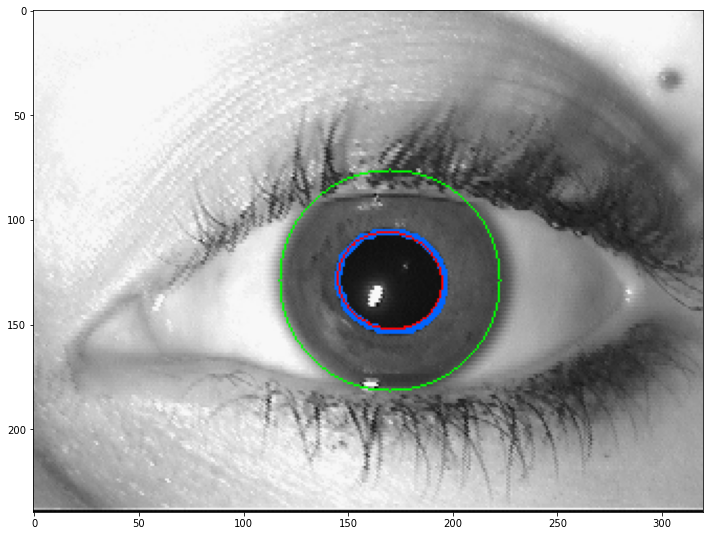

In [1329]:
def get_iris_radius(poi_geom, cent_geom):
    if not poi_geom:
        return 0
    possible_rad = [distance_between(point, cent_geom) for point in poi_geom]
    most_possible_rad = [distance_between(point, cent_geom) for point in poi_geom 
                         if distance_between(point, cent_geom) < 2.4 * radius_pupil]
    if most_possible_rad:
        radius_iris = int(np.median(most_possible_rad))
    else:
        radius_iris = int(np.median(possible_rad))
    return radius_iris

radius_iris = get_iris_radius(poi_geom, cent_geom)
cv2.circle(img_color, center, radius_iris, (0, 255, 0))
plot(img_color)

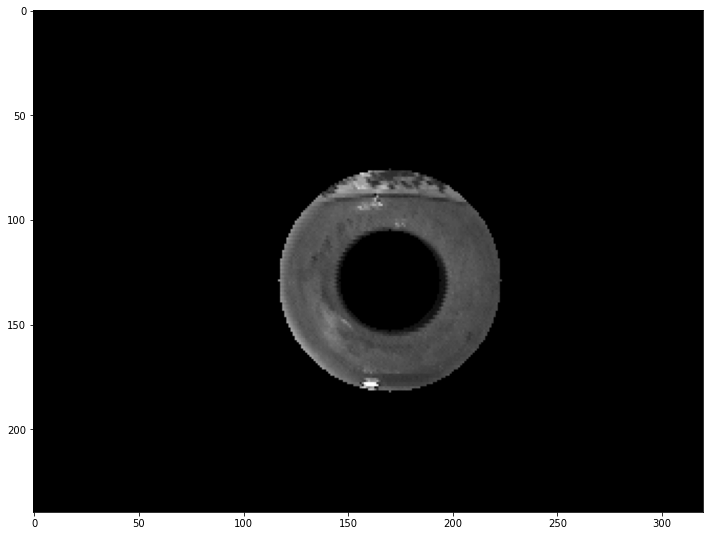

In [1330]:
# create iris mask
image_copy = image.copy()
mask_pupil = np.zeros_like(image)
mask_pupil = cv2.circle(mask_pupil, center, radius_pupil, (255,255,255), -1)
mask_iris = np.zeros_like(image)
mask_iris = cv2.circle(mask_iris, center, radius_iris, (255,255,255), -1)
mask = cv2.subtract(mask_iris, mask_pupil)
plot_gray(cv2.bitwise_and(image_copy, image_copy, mask=mask))

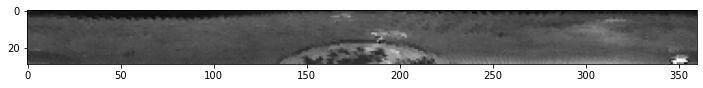

In [1331]:
# polar to cartesian (unwrap image into rectangle)
import cmath
import math

def polar_to_cart(image, center):
    result = np.zeros((radius_iris - radius_pupil, 360, 3), np.uint8)
    for phi in range(360):
        for r in range(radius_pupil, radius_iris):
            target = cmath.rect(r, math.radians(phi))
            result[r-radius_pupil, phi] = image[int(center[1] + target.real), int(center[0] + target.imag)]
    return result

iris_cart = polar_to_cart(image_copy, center)
plot_gray(iris_cart)

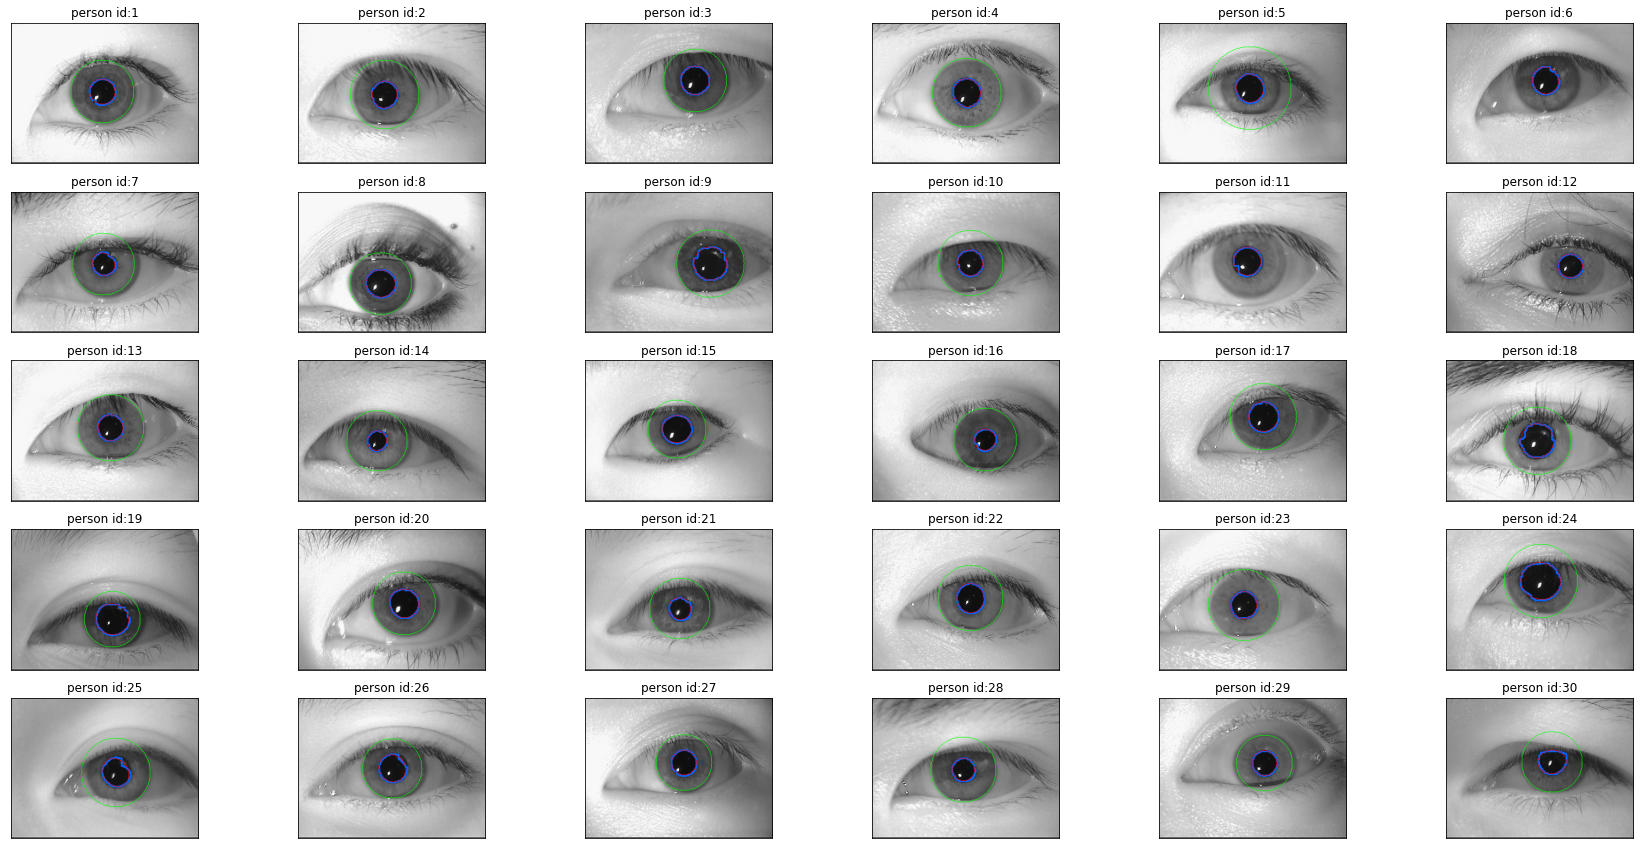

In [1332]:
# visualization for different persons
root = "MMU_Iris_v1"
all_images = get_all_images(root)
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(30, 15))
ax = ax.flatten()
for i in range(30):
    image_index = i * 10
    image = all_images[image_index]
    thr, thr2 = get_pupil(image)
    thr_inv = get_pupil_inv(thr2)
    cnt, ell = fit_ellipse(thr_inv)
    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    center, radius_pupil = draw_pupil(img_color, cnt, ell)
    image_blurred = cv2.GaussianBlur(image, (3,3), 0)
    edges = cv2.Canny(image_blurred, 40, 140)
    cent_geom = [center[0], edges.shape[0] - center[1]]
    poi, poi_geom = extract_poi(edges, cent_geom, radius_pupil, margin=20, eps=0.4)
    radius_iris = get_iris_radius(poi_geom, cent_geom)
    if radius_iris != 0:
        cv2.circle(img_color, center, radius_iris, (0, 255, 0))
        
    ax[i].imshow(img_color, cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"person id:{i + 1}")

In [1333]:
# Hough circles
# path = "MMU_Iris_v1\\2\\left\\bryanl5.bmp"

# image = read_image(path)
# image_blurred = cv2.GaussianBlur(image,(3,3),0)
# edges = cv2.Canny(image_blurred, 40, 140)
# plot_gray(edges)
# circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 120, param1=30, param2=10, minRadius=25, maxRadius=100)
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     for i in circles[0, :]:
#         center = (i[0], i[1])
#         radius = i[2]
#         image_exp_iris = cv2.circle(image, center, radius, (255, 0, 255), 3)
# img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# plot(img_color)

In [1334]:
# create a dataset out of rectangular iris images
import tensorflow as tf